In [1]:
%matplotlib inline
%time from hikyuu.interactive import *
from pylab import plot
import h5py
from hikyuu.indicator import *

2025-03-23 00:14:27,769 [INFO] runing in interactive session [<module>] (C:\Users\25858\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hikyuu\__init__.py:118) [hikyuu::hku_info]
2025-03-23 00:14:27,772 [INFO] running in jupyter [<module>] (C:\Users\25858\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\hikyuu\__init__.py:125) [hikyuu::hku_info]


2025-03-23 00:14:27.792 [HKU-I] - Using SQLITE3 BaseInfoDriver (BaseInfoDriver.cpp:57)
2025-03-23 00:14:27.810 [HKU-I] - Loading market information... (StockManager.cpp:482)
2025-03-23 00:14:27.811 [HKU-I] - Loading stock type information... (StockManager.cpp:500)
2025-03-23 00:14:27.811 [HKU-I] - Loading stock information... (StockManager.cpp:402)
2025-03-23 00:14:27.898 [HKU-I] - Loading stock weight... (StockManager.cpp:518)
2025-03-23 00:14:28.011 [HKU-I] - Loading block... (StockManager.cpp:113)
2025-03-23 00:14:28.147 [HKU-I] - Loading KData... (StockManager.cpp:117)
2025-03-23 00:14:28.147 [HKU-I] - Preloading all day kdata to buffer ! (StockManager.cpp:160)
2025-03-23 00:14:28.148 [HKU-I] - 0.34s Loaded Data. (StockManager.cpp:125)
CPU times: total: 2.77 s
Wall time: 8.97 s


In [2]:
from tqdm import tqdm
from utils import *
h5_file = 'daily_rps.h5'
# df_rps10 = read_rps_file(h5_file, rps_period)
# df_rps20 = read_rps_file(h5_file, rps_period)
df_rps50 = read_rps_file(h5_file, 50)
# df_rps120 = read_rps_file(h5_file, 120)
# df_rps250 = read_rps_file(h5_file, 250)

读取 daily_rps.h5 中的RPS50数据...


读取RPS50数据: 100%|████████████████████████| 292/292 [00:30<00:00,  9.50it/s]


共读取 292 个交易日的RPS50数据
共涉及 3401 只股票


In [73]:
class RPSSignal(SignalBase):
    def __init__(self, n=20):
        super(RPSSignal, self).__init__("RPSSignal")
        self.set_param("n", n)

    def _clone(self):
        return RPSSignal()

    def rps(self, code, n=50):
        rpsdf = df_rps50
        match n:
            case 50:
                rpsdf = df_rps50
            case 120:
                rpsdf = df_rps120
            case 250:
                rpsdf = df_rps250
            case _:
                print("err: unsupport rps: " + str(n))
                return
        fake = '000001'
        if code not in rpsdf.columns:
            print("err: " + code + " has no rps " + str(n))
            code = fake
        # print(f"read rps{n} of {code}")
        return df_to_ind(rpsdf, code, col_date='datetime')
    
    def _calculate(self, k):
        n = self.get_param("n")
        code = k.get_stock().code
        c = CLOSE(k)

        red_limit = 60
        
        r50 = self.rps(code, 50)
        # r120 = self.rps(code, 120)
        # r250 = self.rps(code, 250)

        r50 = ALIGN(r50,k)
        # 两线红
        # red = (r120 >= red_limit) & (r250>=red_limit)
        
        for i in range(c.discard, len(k)):
            # print(r50[i])
            if (r50[i]>=90):
                # print("buy " + code + " at " + str(k[i].datetime))
                self._add_buy_signal(k[i].datetime)
            elif (r50[i]<90):
                self._add_sell_signal(k[i].datetime)
        # c = CLOSE(k)
        # h = REF(HHV(c, n), 1)  # 前n日高点
        # L = REF(LLV(c, n), 1)  # 前n日低点
        # for i in range(h.discard, len(k)):
        #     if (c[i] >= h[i]):
        #         self._add_buy_signal(k[i].datetime)
        #     elif (c[i] <= L[i]):
        #         self._add_sell_signal(k[i].datetime)

In [74]:
# 测试对象
from utils import *
stks = [get_stock(g) for g in read_guchi("guchi_test.txt")]
# stks = [get_stock(g) for g in read_guchi("guchi.EBK")]
stks = [s for s in stks if s.valid]
stks = [s for s in sm.get_block("指数板块", "沪深300")]
# stks = [get_stock("sh605499")]
time = Datetime(20240101)
money = 100000
len(stks)

300

In [90]:

# 创建一个系统策略
my_mm = MM_Nothing()
# my_sg = SG_Flex(EMA(CLOSE(), n=5), slow_n=10)
my_sg = RPSSignal(10)
my_sys = SYS_Simple(sg=my_sg, mm=my_mm)
# 创建一个选择算法，用于在每日选定交易系统
# my_se = SE_Fixed(stks, my_sys)
my_se = SE_Signal(stks, my_sys)
# 创建一个资产分配器，用于确定如何在选定的交易系统中进行资产分配
my_af = AF_EqualWeight()
# 创建资产组合
my_tm = crtTM(time, money)
my_pf = PF_Simple(tm=my_tm, af=my_af, se=my_se, adjust_mode='day', adjust_cycle=5)
# my_pf = PF_WithoutAF(tm=my_tm, se=my_se)

In [91]:
# 运行投资组合
%time my_pf.run(Query(time),force=True)

err: 300450 has no rps 50
err: 688169 has no rps 50
err: 688008 has no rps 50
err: 688012 has no rps 50
err: 688271 has no rps 50
err: 300014 has no rps 50
err: 300015 has no rps 50
err: 300033 has no rps 50
err: 300059 has no rps 50
err: 300122 has no rps 50
err: 300124 has no rps 50
err: 300274 has no rps 50
err: 300308 has no rps 50
err: 300316 has no rps 50
err: 300347 has no rps 50
err: 300394 has no rps 50
err: 300408 has no rps 50
err: 300413 has no rps 50
err: 300418 has no rps 50
err: 688111 has no rps 50
err: 300433 has no rps 50
err: 300442 has no rps 50
err: 300498 has no rps 50
err: 300502 has no rps 50
err: 300628 has no rps 50
err: 300661 has no rps 50
err: 300750 has no rps 50
err: 300759 has no rps 50
err: 300760 has no rps 50
err: 300782 has no rps 50
err: 300832 has no rps 50
err: 300896 has no rps 50
err: 300979 has no rps 50
err: 300999 has no rps 50
err: 301269 has no rps 50
err: 688223 has no rps 50
err: 688981 has no rps 50
err: 688303 has no rps 50
err: 688041 

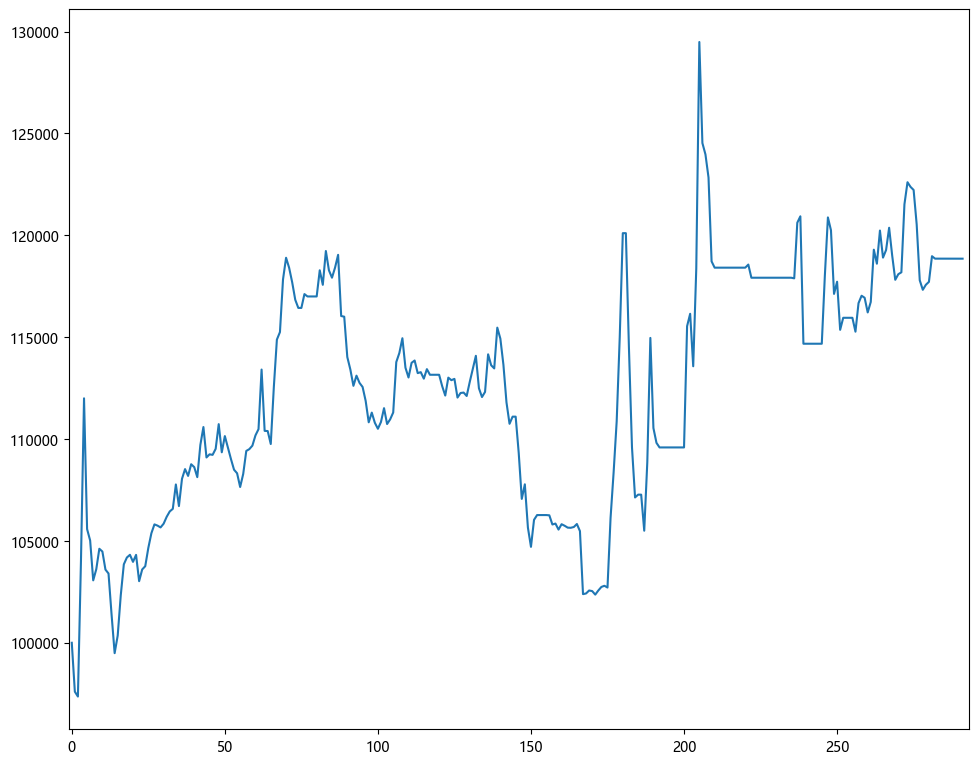

In [92]:
x = my_tm.get_funds_curve(sm.get_trading_calendar(Query(time)))
PRICELIST(x).plot()



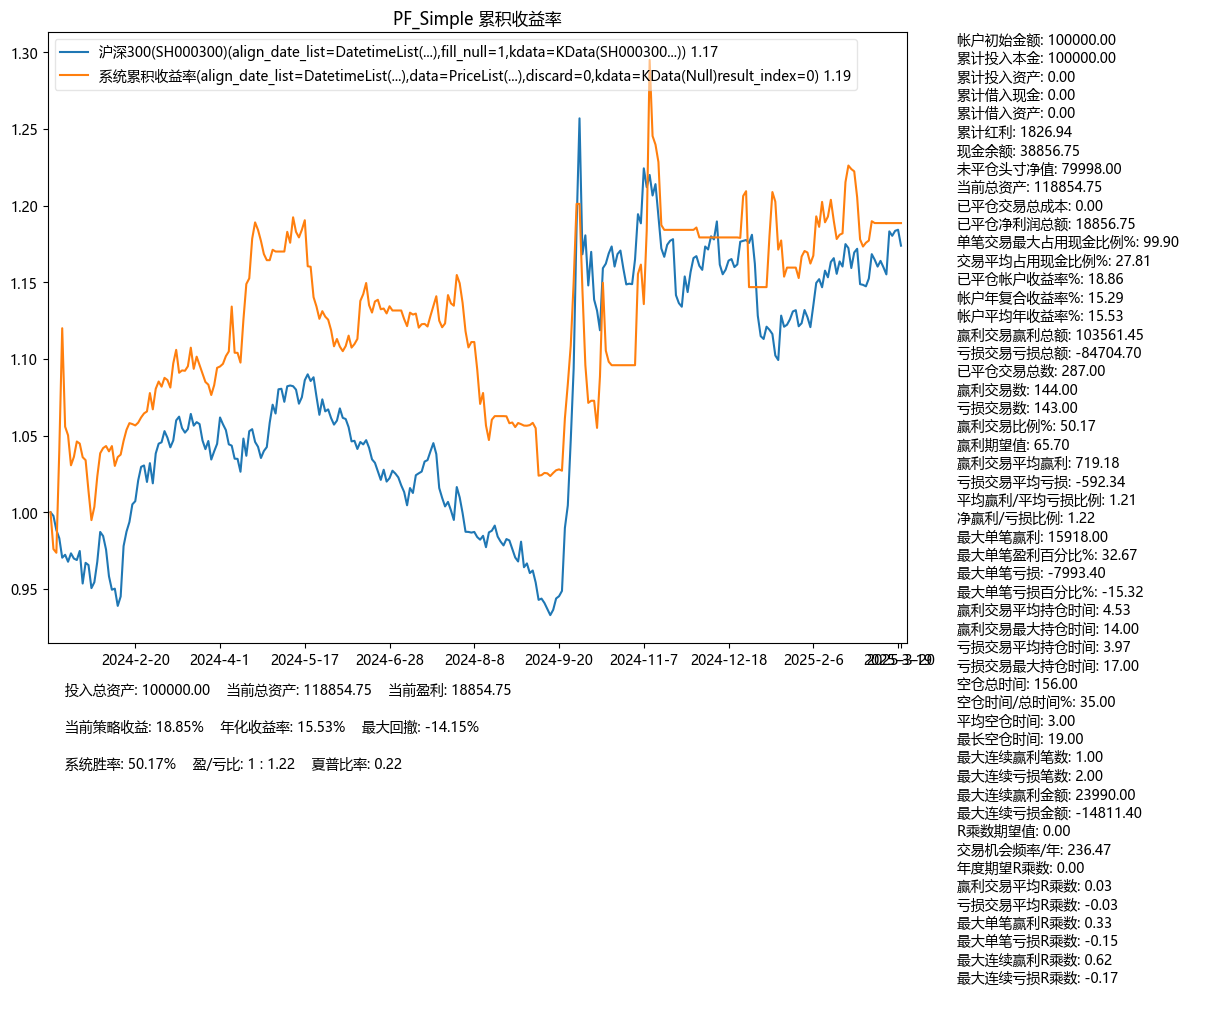

In [93]:
my_pf.performance()

In [94]:
df = my_tm.get_trade_list().to_df()
df.query('业务名称 == "BUY"')

,证券代码,证券名称,业务名称,计划交易价格,实际成交价格,目标价格,成交数量,佣金,印花税,过户费,其它成本,交易总成本,止损价,现金余额,信号来源
交易日期,,,,,,,,,,,,,,,
2024-01-03,SH603392,万泰生物,BUY,77.00,77.00,NaN,1200,0.0,0.0,0.0,0.0,0.0,0.0,7600.00,SG
2024-01-10,SH601898,中煤能源,BUY,10.67,10.67,NaN,3200,0.0,0.0,0.0,0.0,0.0,0.0,71436.00,SG
2024-01-10,SZ000983,山西焦煤,BUY,10.65,10.65,NaN,3300,0.0,0.0,0.0,0.0,0.0,0.0,36291.00,SG
2024-01-10,SH601699,潞安环能,BUY,23.26,23.26,NaN,1500,0.0,0.0,0.0,0.0,0.0,0.0,1401.00,SG
2024-01-17,SH600066,宇通客车,BUY,15.85,15.85,NaN,3200,0.0,0.0,0.0,0.0,0.0,0.0,53758.00,SG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-20,SZ000938,紫光股份,BUY,29.65,29.65,NaN,1300,0.0,0.0,0.0,0.0,0.0,0.0,43104.75,SG
2025-02-20,SH601229,上海银行,BUY,9.40,9.40,NaN,4100,0.0,0.0,0.0,0.0,0.0,0.0,4564.75,SG
2025-02-25,SZ000408,藏格矿业,BUY,33.01,33.01,NaN,1100,0.0,0.0,0.0,0.0,0.0,0.0,43396.75,SG
